In [1]:
### importing libraries

from datetime import datetime,timedelta
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import json
import os
import gc

from lightgbm import LGBMClassifier
import optuna

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix,accuracy_score,auc,classification_report

## load dataset

In [2]:
df1 = pd.read_csv('./data/sensing_data_2.csv')
df1.head()

,user_id,date_time,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,...,year,month,day,hours,minute,weekday,weeknumber,label_source,rating,stress_label
0,u17,2013-03-28 15:08:00,13383,720,109,254,8,7,19,409,...,2013,3,28,15,8,Thu,12,stress_ema,1,0
1,u17,2013-03-30 16:06:00,15997,382,6,111,12,10,23,842,...,2013,3,30,16,6,Sat,12,stress_ema,2,1
2,u17,2013-04-11 16:53:00,15634,738,15,128,11,10,13,736,...,2013,4,11,16,53,Thu,14,stress_ema,3,1
3,u17,2013-04-14 15:33:00,16525,117,0,29,6,6,6,1809,...,2013,4,14,15,33,Sun,14,stress_ema,3,1
4,u17,2013-04-15 14:07:00,15631,669,83,187,15,14,22,1498,...,2013,4,15,14,7,Mon,15,stress_ema,3,1


In [3]:
df1.columns,df1.columns[-10:]

(Index(['user_id', 'date_time', 'activity_inf_stationary_count',
        'activity_inf_walking_count', 'activity_inf_running_count',
        'activity_inf_unknown_count', 'app_usage_baseActivity_mClass',
        'app_usage_baseActivity_mPackage', 'app_usage_baseActivity_id_count',
        'app_usage_baseActivity_numActivities',
        'app_usage_baseActivity_numRunning', 'app_usage_topActivity_mClass',
        'app_usage_topActivity_mPackage', 'audio_inf_silence_count',
        'audio_inf_voice_count', 'audio_inf_noise_count',
        'audio_inf_unknown_count', 'conversation_hours', 'conversation_minutes',
        'dark_hours', 'dark_minutes', 'dark_seconds', 'phonecharge_hours',
        'phonecharge_minutes', 'phonecharge_seconds', 'phonelock_hours',
        'phonelock_minutes', 'phonelock_seconds', 'year', 'month', 'day',
        'hours', 'minute', 'weekday', 'weeknumber', 'label_source', 'rating',
        'stress_label'],
       dtype='object'),
 Index(['year', 'month', 'day', 'hou

In [4]:
df1 = df1.drop(df1.columns[-10:],axis=1)
df1.columns

Index(['user_id', 'date_time', 'activity_inf_stationary_count',
       'activity_inf_walking_count', 'activity_inf_running_count',
       'activity_inf_unknown_count', 'app_usage_baseActivity_mClass',
       'app_usage_baseActivity_mPackage', 'app_usage_baseActivity_id_count',
       'app_usage_baseActivity_numActivities',
       'app_usage_baseActivity_numRunning', 'app_usage_topActivity_mClass',
       'app_usage_topActivity_mPackage', 'audio_inf_silence_count',
       'audio_inf_voice_count', 'audio_inf_noise_count',
       'audio_inf_unknown_count', 'conversation_hours', 'conversation_minutes',
       'dark_hours', 'dark_minutes', 'dark_seconds', 'phonecharge_hours',
       'phonecharge_minutes', 'phonecharge_seconds', 'phonelock_hours',
       'phonelock_minutes', 'phonelock_seconds'],
      dtype='object')

In [6]:
df2 = pd.read_csv('./data/ema_data_2.csv')
df2.head()

,user_id,date_time,number_Social,experience_Class_neutral,experience_Class_st_agree,experience_Class_agree,experience_Class_disagree,experience_Class_st_disagree,due_Class_yes,due_Class_no,...,year,month,day,hours,minute,weekday,weeknumber,label_source,rating,stress_label
0,u22,2013-03-27 00:35:00,0,0,0,0,0,0,0,0,...,2013,3,27,0,35,Wed,12,stress_ema,1,0
1,u22,2013-03-27 15:03:00,2,1,0,0,0,0,0,1,...,2013,3,27,15,3,Wed,12,stress_ema,1,0
2,u22,2013-03-27 20:06:00,2,2,0,1,0,0,0,3,...,2013,3,27,20,6,Wed,12,stress_ema,4,0
3,u22,2013-03-28 00:20:00,22,2,0,1,0,0,0,3,...,2013,3,28,0,20,Thu,12,stress_ema,5,0
4,u22,2013-03-28 03:00:00,232,2,0,1,0,0,0,3,...,2013,3,28,3,0,Thu,12,stress_ema,5,0


In [7]:
df = df1.merge(df2,on=['user_id','date_time'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2455 entries, 0 to 2454
Data columns (total 92 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   user_id                               2455 non-null   object
 1   date_time                             2455 non-null   object
 2   activity_inf_stationary_count         2455 non-null   int64 
 3   activity_inf_walking_count            2455 non-null   int64 
 4   activity_inf_running_count            2455 non-null   int64 
 5   activity_inf_unknown_count            2455 non-null   int64 
 6   app_usage_baseActivity_mClass         2455 non-null   int64 
 7   app_usage_baseActivity_mPackage       2455 non-null   int64 
 8   app_usage_baseActivity_id_count       2455 non-null   int64 
 9   app_usage_baseActivity_numActivities  2455 non-null   int64 
 10  app_usage_baseActivity_numRunning     2455 non-null   int64 
 11  app_usage_topActivity_mClass  

In [9]:
df.describe()

,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,app_usage_baseActivity_numRunning,app_usage_topActivity_mClass,...,grade_C,grade_C_min,year,month,day,hours,minute,weeknumber,rating,stress_label
count,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,...,2455.0,2455.0,2455.0,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000
mean,17247.491650,997.328310,246.898167,655.269246,19.185336,16.978411,30.044807,2305.955193,1329.231772,23.809776,...,0.0,0.0,2013.0,4.224847,15.397963,14.274134,24.409369,15.600815,2.182077,0.291650
std,13703.392908,1390.389219,392.034710,1145.097115,10.315967,8.803937,17.520312,2457.601158,905.765832,13.114196,...,0.0,0.0,0.0,0.664591,9.455342,6.510618,18.665454,2.711081,1.294401,0.454614
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,2013.0,3.000000,1.000000,0.000000,0.000000,12.000000,1.000000,0.000000
25%,13468.000000,391.000000,23.000000,123.000000,12.000000,11.000000,18.000000,895.000000,569.500000,15.000000,...,0.0,0.0,2013.0,4.000000,7.000000,11.000000,7.000000,13.000000,1.000000,0.000000
50%,15026.000000,618.000000,107.000000,250.000000,18.000000,16.000000,27.000000,1765.000000,1142.000000,23.000000,...,0.0,0.0,2013.0,4.000000,15.000000,15.000000,22.000000,15.000000,2.000000,0.000000
75%,15739.000000,959.500000,305.500000,512.500000,25.000000,22.000000,40.000000,2767.500000,1930.500000,32.000000,...,0.0,0.0,2013.0,5.000000,25.000000,19.000000,40.000000,18.000000,3.000000,1.000000
max,75287.000000,11208.000000,7982.000000,8340.000000,73.000000,62.000000,145.000000,18229.000000,6402.000000,97.000000,...,0.0,0.0,2013.0,6.000000,31.000000,23.000000,59.000000,22.000000,5.000000,1.000000


## Dropping columns

In [10]:
df = df.sample(frac= 1,random_state=2022)
df

,user_id,date_time,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,...,year,month,day,hours,minute,weekday,weeknumber,label_source,rating,stress_label
2391,u33,2013-04-04 23:42:00,15458,636,80,142,49,45,53,16757,...,2013,4,4,23,42,Thu,13,stress_ema,1,0
1383,u27,2013-04-15 21:00:00,15361,486,10,379,14,13,58,1287,...,2013,4,15,21,0,Mon,15,stress_ema,1,0
962,u41,2013-04-08 22:47:00,2037,1,0,2,8,7,9,98,...,2013,4,8,22,47,Mon,14,stress_ema,1,0
1063,u39,2013-04-16 23:34:00,16186,147,19,240,6,6,9,616,...,2013,4,16,23,34,Tue,15,stress_ema,1,0
2292,u49,2013-05-16 19:11:00,29497,1314,232,202,24,20,31,2678,...,2013,5,16,19,11,Thu,19,stress_ema,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1713,u08,2013-03-26 19:04:00,0,0,0,0,13,11,20,1185,...,2013,3,26,19,4,Tue,12,stress_ema,2,1
624,u36,2013-04-17 01:55:00,15633,406,132,244,24,20,34,2042,...,2013,4,17,1,55,Wed,15,stress_ema,2,1
173,u51,2013-04-30 17:06:00,15973,226,350,19,7,7,13,682,...,2013,4,30,17,6,Tue,17,stress_ema,3,1
1244,u10,2013-04-08 21:04:00,15544,651,52,114,10,10,18,1421,...,2013,4,8,21,4,Mon,14,stress_ema,5,0


In [11]:
df = df.drop(['user_id','date_time','year','label_source','rating'],axis=1)

df['stress_label'].value_counts()

0    1739
1     716
Name: stress_label, dtype: int64

In [12]:
df['weekday'].value_counts()

Wed    392
Tue    385
Thu    375
Fri    373
Mon    362
Sun    330
Sat    238
Name: weekday, dtype: int64

In [13]:
weekday_map = {"Sat":0,"Sun":1,"Mon":2,"Tue":3,"Wed":4,"Thu":5,"Fri":6}

df['weekday'] = df['weekday'].map(weekday_map)

df['weekday'].value_counts()

4    392
3    385
5    375
6    373
2    362
1    330
0    238
Name: weekday, dtype: int64

In [14]:
df = df.reset_index(drop=True)
df

,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,app_usage_baseActivity_numRunning,app_usage_topActivity_mClass,...,grade_C_plu,grade_C,grade_C_min,month,day,hours,minute,weekday,weeknumber,stress_label
0,15458,636,80,142,49,45,53,16757,3155,59,...,0,0,0,4,4,23,42,5,13,0
1,15361,486,10,379,14,13,58,1287,1205,20,...,0,0,0,4,15,21,0,2,15,0
2,2037,1,0,2,8,7,9,98,94,9,...,0,0,0,4,8,22,47,2,14,0
3,16186,147,19,240,6,6,9,616,608,7,...,0,0,0,4,16,23,34,3,15,0
4,29497,1314,232,202,24,20,31,2678,2443,25,...,0,0,0,5,16,19,11,5,19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2450,0,0,0,0,13,11,20,1185,1071,14,...,0,0,0,3,26,19,4,3,12,1
2451,15633,406,132,244,24,20,34,2042,1685,28,...,0,0,0,4,17,1,55,4,15,1
2452,15973,226,350,19,7,7,13,682,676,8,...,0,0,0,4,30,17,6,3,17,1
2453,15544,651,52,114,10,10,18,1421,1359,12,...,0,0,0,4,8,21,4,2,14,0


## Train val split

In [15]:
df_train,df_val,df_test = df[:(len(df)*3)//5],df[(len(df)*3)//5:(len(df)*4)//5],df[(len(df)*4)//5:]

len(df_train),len(df_val),len(df_test)

(1473, 491, 491)

In [16]:
df_train[df_train.columns[-1]]

0       0
1       0
2       0
3       0
4       0
       ..
1468    0
1469    0
1470    0
1471    0
1472    0
Name: stress_label, Length: 1473, dtype: int64

## LGBM

In [17]:
df_train_x,df_train_y = df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]]
df_val_x,df_val_y = df_val[df_val.columns[:-1]], df_val[df_val.columns[-1]]
df_test_x,df_test_y = df_test[df_test.columns[:-1]], df_test[df_test.columns[-1]]

In [18]:
def objective(trial):
  n_estimators_hp = trial.suggest_int('n_estimators', 50, 1000)
  max_depth_hp =  trial.suggest_int('max_depth', 10, 500)
  min_child_samples_hp = trial.suggest_int('min_child_samples', 10, 100)
  num_leaves_hp = trial.suggest_int('num_leaves', 2, 256)
  learning_rate_hp = trial.suggest_loguniform('learning_rate',1e-5,10)
  
  model = LGBMClassifier(n_estimators = n_estimators_hp, 
                         max_depth = max_depth_hp, 
                         min_child_samples = min_child_samples_hp,
                         num_leaves = num_leaves_hp,
                         learning_rate = learning_rate_hp,
                         random_state = 0,is_unbalance=True)
  
  model.fit(df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]])
  
  pred_probs = model.predict_proba(df_val[df_val.columns[:-1]])
  
  return roc_auc_score(df_val[df_val.columns[-1]], pred_probs[:,1])
  #return precision_score(y_test, y_pred)
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2022-11-25 15:35:35,282] A new study created in memory with name: no-name-7d987c2c-f5d4-4046-9e4a-25e035a1b268
/tmp/ipykernel_2490244/3744688316.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate_hp = trial.suggest_loguniform('learning_rate',1e-5,10)
[I 2022-11-25 15:35:36,123] Trial 0 finished with value: 0.768641930835735 and parameters: {'n_estimators': 698, 'max_depth': 493, 'min_child_samples': 31, 'num_leaves': 15, 'learning_rate': 0.0319969074815888}. Best is trial 0 with value: 0.768641930835735.
/tmp/ipykernel_2490244/3744688316.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate_hp = trial.suggest_logun

In [19]:
print('Best trial:', study.best_trial.params)
trial = study.best_trial
print("  Value: {}".format(trial.value))


# Best trial: {'n_estimators': 308, 'max_depth': 115, 'min_child_samples': 13, 'num_leaves': 81, 'learning_rate': 0.019937858608472442}
#   Value: 0.7868335734870318

Best trial: {'n_estimators': 308, 'max_depth': 115, 'min_child_samples': 13, 'num_leaves': 81, 'learning_rate': 0.019937858608472442}
  Value: 0.7868335734870318


In [21]:
# model = LGBMClassifier(**study.best_trial.params, random_state = 0,is_unbalance=True )

model = LGBMClassifier(**{'n_estimators': 308, 'max_depth': 115, 'min_child_samples': 13, 'num_leaves': 81, 'learning_rate': 0.019937858608472442}, random_state = 0,is_unbalance=True )
 
model.fit(df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]])
 
roc_auc_score(df_test[df_test.columns[-1]], model.predict_proba(df_test[df_test.columns[:-1]])[:,1])

0.747003745318352

In [22]:
fpr, tpr, _ = roc_curve(df_test[df_test.columns[-1]], model.predict_proba(df_test[df_test.columns[:-1]])[:,1])
roc_auc = auc(fpr, tpr)

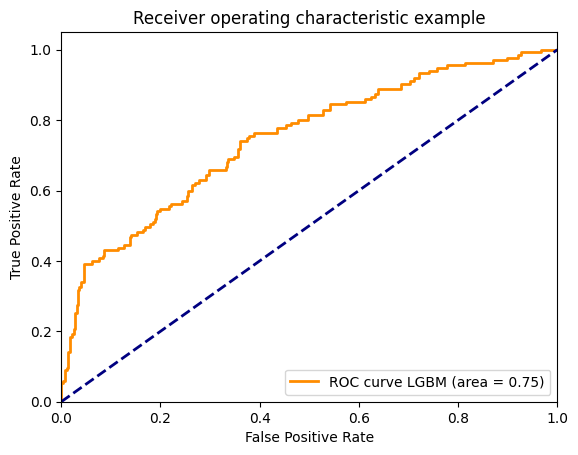

In [23]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve LGBM (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [24]:
print(classification_report(df_test[df_test.columns[-1]], model.predict(df_test[df_test.columns[:-1]])))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       356
           1       0.56      0.47      0.51       135

    accuracy                           0.75       491
   macro avg       0.68      0.66      0.67       491
weighted avg       0.74      0.75      0.74       491



In [25]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,df_train_x.columns),reverse=True), columns=['Value','Feature'])
feature_imp

,Value,Feature
0,1538,minute
1,1312,activity_inf_unknown_count
2,1262,activity_inf_walking_count
3,1125,audio_inf_silence_count
4,1058,audio_inf_voice_count
...,...,...
81,0,grade_B_min
82,0,grade_B
83,0,effort_Class 2 no
84,0,challenge_Class 2 no


## Log reg

In [26]:
df_train_x,df_train_y = df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]]
df_val_x,df_val_y = df_val[df_val.columns[:-1]], df_val[df_val.columns[-1]]
df_test_x,df_test_y = df_test[df_test.columns[:-1]], df_test[df_test.columns[-1]]


df_train_x.shape,df_train_y.shape,df_val_x.shape,df_val_y.shape,df_test_x.shape,df_test_y.shape

((1473, 86), (1473,), (491, 86), (491,), (491, 86), (491,))

In [27]:
sc = StandardScaler()
sc = sc.fit(df_train_x)

df_train_x_sc = sc.transform(df_train_x)
df_val_x_sc = sc.transform(df_val_x)
df_test_x_sc = sc.transform(df_test_x)

In [28]:
def objective(trial):
  c_hp = trial.suggest_float('C', 0.0001, 100)
  
  
  model = LogisticRegression(C = c_hp, 
                         
                         random_state = 0,class_weight="balanced",n_jobs = -1)
  
  model.fit(df_train_x_sc, df_train_y)
  
  pred_probs = model.predict_proba(df_val_x_sc)
  
  return roc_auc_score(df_val_y, pred_probs[:,1])
  #return precision_score(y_test, y_pred)
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2022-11-25 15:37:26,477] A new study created in memory with name: no-name-d5e7589d-efc5-4d76-a6fa-e648f88fd9bd
/home/sidd/anaconda3/envs/ucsd_hw/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2022-11-25 15:37:27,299] Trial 0 finished with value: 0.6830371437720141 and parameters: {'C': 86.6622144156259}. Best is trial 0 with value: 0.6830371437720141.
/home/sidd/anaconda3/envs/ucsd_hw/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATION

In [29]:
print('Best trial:', study.best_trial.params)
trial = study.best_trial
print("  Value: {}".format(trial.value))

# Best trial: {'C': 43.06041380681798}
#   Value: 0.683597502401537

Best trial: {'C': 43.06041380681798}
  Value: 0.683597502401537


In [30]:
# model = LGBMClassifier(**study.best_trial.params, random_state = 0,is_unbalance=True )

model = LogisticRegression(**{'C': 43.06041380681798}, random_state = 0,class_weight="balanced",n_jobs = -1)
 
model.fit(df_train_x_sc, df_train_y)
 
roc_auc_score(df_test_y, model.predict_proba(df_test_x_sc)[:,1])

0.7044943820224718

In [31]:
fpr, tpr, _ = roc_curve(df_test_y, model.predict_proba(df_test_x_sc)[:,1])
roc_auc = auc(fpr, tpr)

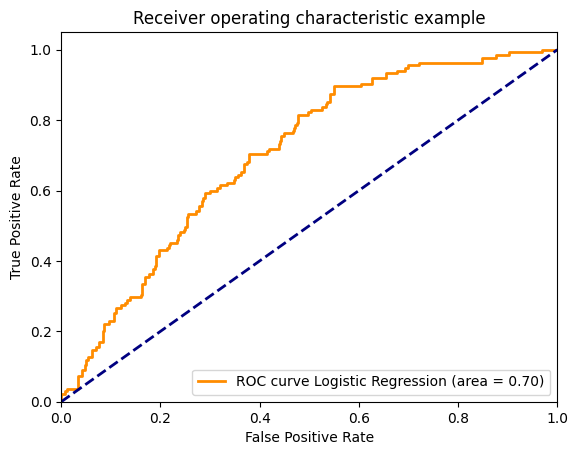

In [32]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve Logistic Regression (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [33]:
print(classification_report(df_test_y, model.predict(df_test_x_sc)))

              precision    recall  f1-score   support

           0       0.84      0.62      0.72       356
           1       0.41      0.70      0.52       135

    accuracy                           0.64       491
   macro avg       0.63      0.66      0.62       491
weighted avg       0.72      0.64      0.66       491



## SVM

In [34]:
def objective(trial):
  c_hp = trial.suggest_float('C', 0.001, 100)
  
  
  model = SVC(C = c_hp, 
                         
                         random_state = 0,class_weight="balanced",probability = True)
  
  model.fit(df_train_x_sc, df_train_y)
  
  pred_probs = model.predict_proba(df_val_x_sc)
  
  return roc_auc_score(df_val_y, pred_probs[:,1])
  #return precision_score(y_test, y_pred)
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2022-11-25 15:38:03,855] A new study created in memory with name: no-name-77a4c0c6-ef06-4f06-8bc9-491510ded958
[I 2022-11-25 15:38:04,341] Trial 0 finished with value: 0.7203610310598783 and parameters: {'C': 79.61661905005124}. Best is trial 0 with value: 0.7203610310598783.
[I 2022-11-25 15:38:04,814] Trial 1 finished with value: 0.7244036183157221 and parameters: {'C': 57.593321822288196}. Best is trial 1 with value: 0.7244036183157221.
[I 2022-11-25 15:38:05,287] Trial 2 finished with value: 0.7246837976304835 and parameters: {'C': 56.262081368078064}. Best is trial 2 with value: 0.7246837976304835.
[I 2022-11-25 15:38:05,758] Trial 3 finished with value: 0.7255043227665706 and parameters: {'C': 53.36486757248339}. Best is trial 3 with value: 0.7255043227665706.
[I 2022-11-25 15:38:06,170] Trial 4 finished with value: 0.739193083573487 and parameters: {'C': 13.370549350725948}. Best is trial 4 with value: 0.739193083573487.
[I 2022-11-25 15:38:06,624] Trial 5 finished with value

In [35]:
print('Best trial:', study.best_trial.params)
trial = study.best_trial
print("  Value: {}".format(trial.value))

# Best trial: {'C': 13.843442800296756}
#   Value: 0.7392331091898815

Best trial: {'C': 13.843442800296756}
  Value: 0.7392331091898815


In [36]:
# model = LGBMClassifier(**study.best_trial.params, random_state = 0,is_unbalance=True )

model = SVC(**{'C': 13.843442800296756}, random_state = 0,class_weight="balanced",probability = True)
 
model.fit(df_train_x_sc, df_train_y)
 
roc_auc_score(df_test_y, model.predict_proba(df_test_x_sc)[:,1])

0.7249271743653765

In [37]:
fpr, tpr, _ = roc_curve(df_test_y, model.predict_proba(df_test_x_sc)[:,1])
roc_auc = auc(fpr, tpr)

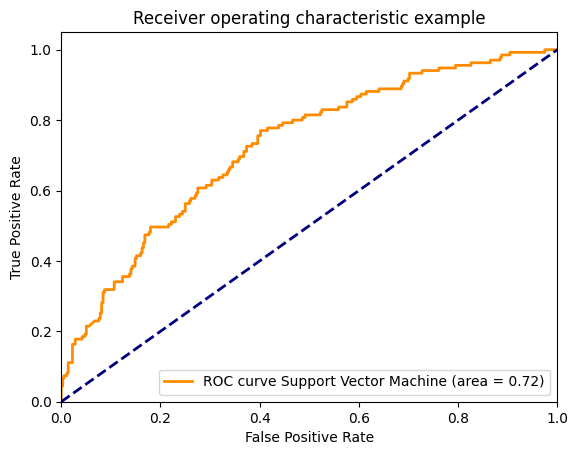

In [38]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve Support Vector Machine (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [39]:
print(classification_report(df_test_y, model.predict(df_test_x_sc)))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78       356
           1       0.46      0.56      0.51       135

    accuracy                           0.70       491
   macro avg       0.64      0.66      0.64       491
weighted avg       0.72      0.70      0.71       491



## Random forest

In [40]:
df_train_x,df_train_y = df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]]
df_val_x,df_val_y = df_val[df_val.columns[:-1]], df_val[df_val.columns[-1]]
df_test_x,df_test_y = df_test[df_test.columns[:-1]], df_test[df_test.columns[-1]]


df_train_x.shape,df_train_y.shape,df_val_x.shape,df_val_y.shape,df_test_x.shape,df_test_y.shape

((1473, 86), (1473,), (491, 86), (491,), (491, 86), (491,))

In [41]:
def objective(trial):
  n_estimators_hp = trial.suggest_int('n_estimators', 50, 1000)
  max_depth_hp =  trial.suggest_int('max_depth', 10, 100)
  min_child_samples_hp = trial.suggest_int('min_samples_split', 10, 100)
  num_leaves_hp = trial.suggest_int('min_samples_leaf', 2, 256)
  
  
  model = RandomForestClassifier(n_estimators = n_estimators_hp, 
                         max_depth = max_depth_hp, 
                         min_samples_split = min_child_samples_hp,
                         min_samples_leaf = num_leaves_hp,
                         
                         random_state = 0,class_weight="balanced",n_jobs = -1)
  
  model.fit(df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]])
  
  pred_probs = model.predict_proba(df_val[df_val.columns[:-1]])
  
  return roc_auc_score(df_val[df_val.columns[-1]], pred_probs[:,1])
  #return precision_score(y_test, y_pred)
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2022-11-25 15:39:10,001] A new study created in memory with name: no-name-a60aba49-d9b6-4a13-a36b-d96c9ab94cc2
[I 2022-11-25 15:39:12,525] Trial 0 finished with value: 0.6984269932756965 and parameters: {'n_estimators': 919, 'max_depth': 79, 'min_samples_split': 26, 'min_samples_leaf': 56}. Best is trial 0 with value: 0.6984269932756965.
[I 2022-11-25 15:39:13,769] Trial 1 finished with value: 0.6926532981107908 and parameters: {'n_estimators': 315, 'max_depth': 24, 'min_samples_split': 15, 'min_samples_leaf': 52}. Best is trial 0 with value: 0.6984269932756965.
[I 2022-11-25 15:39:18,147] Trial 2 finished with value: 0.6814161063080372 and parameters: {'n_estimators': 963, 'max_depth': 63, 'min_samples_split': 72, 'min_samples_leaf': 109}. Best is trial 0 with value: 0.6984269932756965.
[I 2022-11-25 15:39:18,858] Trial 3 finished with value: 0.6787143772014088 and parameters: {'n_estimators': 181, 'max_depth': 78, 'min_samples_split': 62, 'min_samples_leaf': 139}. Best is trial 0 

In [42]:
print('Best trial:', study.best_trial.params)
trial = study.best_trial
print("  Value: {}".format(trial.value))

# Best trial: {'n_estimators': 809, 'max_depth': 19, 'min_samples_split': 19, 'min_samples_leaf': 3}
#   Value: 0.7569544508485431

Best trial: {'n_estimators': 809, 'max_depth': 19, 'min_samples_split': 19, 'min_samples_leaf': 3}
  Value: 0.7569544508485431


In [43]:
# model = LGBMClassifier(**study.best_trial.params, random_state = 0,is_unbalance=True )

model = RandomForestClassifier(**{'n_estimators': 809, 'max_depth': 19, 'min_samples_split': 19, 'min_samples_leaf': 3},random_state = 0 ,class_weight="balanced",n_jobs = -1)
 
model.fit(df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]])
 
roc_auc_score(df_test[df_test.columns[-1]], model.predict_proba(df_test[df_test.columns[:-1]])[:,1])

0.7334789846025801

In [44]:
fpr, tpr, _ = roc_curve(df_test[df_test.columns[-1]], model.predict_proba(df_test[df_test.columns[:-1]])[:,1])
roc_auc = auc(fpr, tpr)

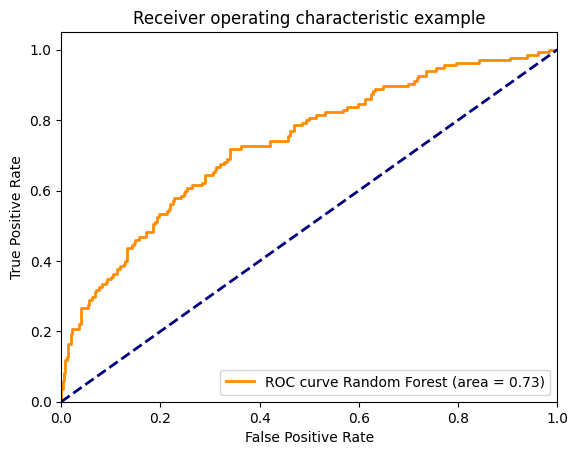

In [45]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve Random Forest (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [46]:
print(classification_report(df_test[df_test.columns[-1]], model.predict(df_test[df_test.columns[:-1]])))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       356
           1       0.51      0.47      0.49       135

    accuracy                           0.73       491
   macro avg       0.66      0.65      0.65       491
weighted avg       0.73      0.73      0.73       491



In [47]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,df_train_x.columns),reverse=True), columns=['Value','Feature'])
feature_imp

,Value,Feature
0,0.053288,activity_inf_unknown_count
1,0.038160,day
2,0.038018,weeknumber
3,0.037277,activity_inf_stationary_count
4,0.037016,activity_inf_walking_count
...,...,...
81,0.000000,grade_C_min
82,0.000000,grade_C
83,0.000000,grade_B_min
84,0.000000,effort_Class 2 no


## End